In [1]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Baseline Models

In this notebook, we will build a couple of baseline models using `DummyRegression` and `permutation_test_score`. We will compare performance of our linear regression model with these two baselines.

We will use `ShuffleSplit` as a cross validation strategy.

In [3]:
from sklearn.model_selection import ShuffleSplit
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test.

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

## `LinearRegression`

We first build the model, whose performance we want to compare against the baseline models. 

- In this case we build a linear regression model with feature scaling as a part of the pipeline.
- Train the model with a $10$-fold cross validation via `ShuffleSplit`.
- Capture errors on different folds.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lin_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('lin_reg', LinearRegression()),
])

lin_reg_cv_results = cross_validate(
    lin_reg_pipeline,
    train_features,
    train_labels,
    scoring='neg_mean_absolute_error',
    cv=shuffle_split_cv,
    n_jobs=2
    # We don't want training scores, so we have allowed it to remain default 'False'
)

In [20]:
lin_reg_cv_results

{'fit_time': array([0.01666093, 0.01663733, 0.00627494, 0.00697803, 0.005867  ,
        0.00660515, 0.00607419, 0.00683093, 0.00640821, 0.00553989]),
 'score_time': array([0.00339198, 0.00370574, 0.00156021, 0.00167513, 0.00157881,
        0.00158691, 0.00270796, 0.00158119, 0.00213599, 0.00141501]),
 'test_score': array([-0.51591748, -0.53167776, -0.5409238 , -0.52867599, -0.54905644,
        -0.52552564, -0.52893409, -0.53502143, -0.51971413, -0.54272157])}

In [21]:
lin_reg_scores = lin_reg_cv_results['test_score']
lin_reg_errors = pd.Series(-lin_reg_scores, name="Linear Regression Errors")
print(lin_reg_errors)

0    0.515917
1    0.531678
2    0.540924
3    0.528676
4    0.549056
5    0.525526
6    0.528934
7    0.535021
8    0.519714
9    0.542722
Name: Linear Regression Errors, dtype: float64


## `DummyRegressor`

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. 

`DummyRegressor` implements four simple rules of thumb for regression:

- `mean` always predicts the mean of the training targets.
- `median` always predicts the median of the training targets.
- `quantile` always predicts a user provided quantile of the training targets.
- `constant` always predicts a constant value that is provided by the user.

In all these strategies, the `predict` method completely ignores the input data.

We compare the performance of our model against these strategies, to check whether we are gaining any meaningful information or not. If `DummyRegressor` scores better than our model, we need to re-think our model strategy.

In [23]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

def dummy_regressor_baseline(strategy, constant_val=None, quatile_val=None):
    # The DummyRegressor model
    baseline_model_median = DummyRegressor(
        strategy=strategy,
        constant=constant_val,
        quantile=quatile_val,
    )

    # Cross-validating the dummy model to obtain its score
    baseline_median_cv_results = cross_validate(
        baseline_model_median,
        train_features,
        train_labels,
        scoring='neg_mean_absolute_error',
        cv=shuffle_split_cv,
        n_jobs=2,
    )

    # This returns the tests score of the dummy regressor for each fold
    return pd.Series(-baseline_median_cv_results['test_score'], name="Dummy Regressor Errors, strategy = " + str(strategy))

We now extract the errors obtained by employing different strategies for `DummyRegressor`.

In [24]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')

baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')

baseline_constant_cv_results_errors = dummy_regressor_baseline(strategy='constant', constant_val=2)

baseline_quantile_cv_results_errors = dummy_regressor_baseline(strategy='quantile', quatile_val=0.55)
#55% quantile (close to median)

Let's compare the performance of these dummy regressors:

In [25]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors, baseline_mean_cv_results_errors, baseline_constant_cv_results_errors, baseline_quantile_cv_results_errors], axis=1)

dummy_error_df.columns = ['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']

<Figure size 576x396 with 0 Axes>

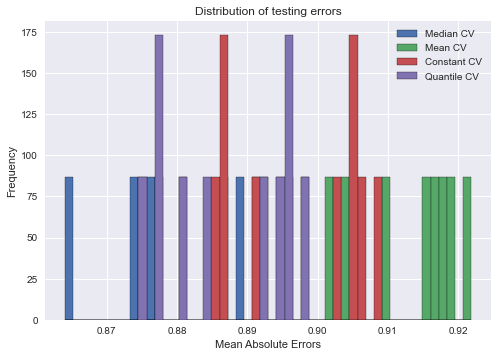

In [26]:
plt.figure()
dummy_error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend()
plt.xlabel("Mean Absolute Errors")
plt.title("Distribution of testing errors")
plt.show()

We can observe from this plot that the `median` strategy provides the lowest values of errors, where as the `mean` stratedy provides the highest errors.

In [27]:
print(baseline_median_cv_results_errors)

0    0.881187
1    0.873773
2    0.876366
3    0.892083
4    0.876835
5    0.874685
6    0.864097
7    0.888523
8    0.890963
9    0.886765
Name: Dummy Regressor Errors, strategy = median, dtype: float64


## `permutation_test_score`

It permutes the target to generate randomized data and computes the empirical p-value against the null hypothesis, that features and targets are independent.

Here, we are interested in `permutation_score` returned by this API, which indicates score of the model on different permutations

In [33]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    lin_reg_pipeline,
    train_features,
    train_labels,
    cv=shuffle_split_cv,
    scoring='neg_mean_absolute_error',
    n_permutations=30,
    n_jobs=2,
)

permutation_errors = pd.Series(-permutation_scores, name="Permutation Errors")

In [34]:
print(permutation_scores)
print(permutation_errors)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]
0     0.914465
1     0.916087
2     0.915011
3     0.911122
4     0.913261
5     0.914287
6     0.916943
7     0.906607
8     0.908736
9     0.915461
10    0.908469
11    0.911740
12    0.918571
13    0.914671
14    0.903967
15    0.912393
16    0.910955
17    0.917296
18    0.905294
19    0.914366
20    0.919930
21    0.916619
22    0.911047
23    0.915632
24    0.910143
25    0.915261
26    0.906802
27    0.907964
28    0.910330
29    0.915456
Name: Permutation Errors, dtype: float64


## Model Comparison

We finally compare the errors of each of these models and check whether our proposed model out performs the dummy models.

In [35]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_errors], axis=1)

<Figure size 576x396 with 0 Axes>

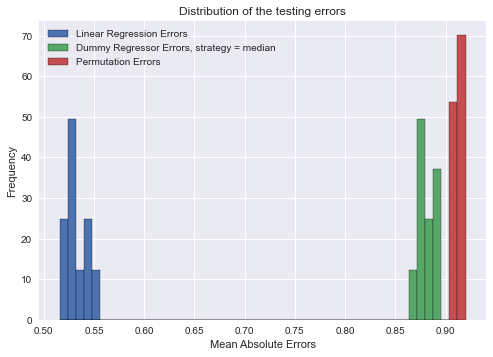

In [36]:
plt.figure()
error_df.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(loc='best')
plt.xlabel("Mean Absolute Errors")
plt.title("Distribution of the testing errors")
plt.show()

From this plot, it is clear that our model has better performance than the two baseline models.

### Summary

We implemented a couple of baselines - based on `DummyRegressor` and `permutation_test_score`.

Although we used all strategies for `DummyRegressor`, we need to use only one of these strategies depending on the dataset.